ma cross strategy
===


## Abstract

- 多方訊號：符合 ma_5 > ma_10 > ma_20 股票數量（%）
- 空方訊號：符合 ma_5 < ma_10 < ma_20 股票數量（%）

- 進場：多方訊號黃金交叉空方訊號
- 出場：多方訊號死亡交叉空方訊號

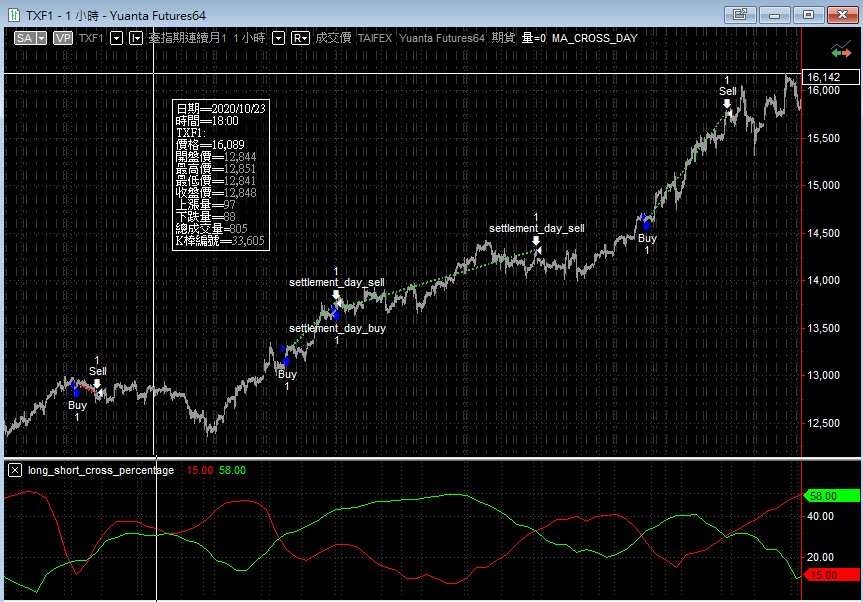

In [2]:
from IPython.display import Image
Image(filename="img/1.jpeg", width=750, height=500)

## Import Libraries

In [3]:
# Standard Libraries
import os
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import time
import sys
import warnings
from collections import defaultdict
import json
import requests
import matplotlib.pyplot as plt
import pymysql
from sqlalchemy import create_engine
import MySQLdb
import MySQLdb.cursors

# Crawling Libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

# Api Libraries
import shioaji as sj
import yfinance as yf
from FinMind.data import DataLoader


## 爬取股票上、下市（櫃）資訊

In [4]:
# fetch current all 上市股票 id 
url = "https://isin.twse.com.tw/isin/C_public.jsp?strMode=2"
res = requests.get(url)
df = pd.read_html(res.text)[0]
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.dropna(thresh=3, axis=0).dropna(thresh=3, axis=1)
df = df[df['CFICode'] == 'ESVUFR']
stocks = list(df['有價證券代號及名稱'])
stocks_02 = set([item[:4] for item in stocks])
print(f"成功獲取目前上市股票ID: {len(stocks_02)} 檔")


# fetch current all 上櫃股票 id 
url = "https://isin.twse.com.tw/isin/C_public.jsp?strMode=4"
res = requests.get(url)
df = pd.read_html(res.text)[0]
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.dropna(thresh=3, axis=0).dropna(thresh=3, axis=1)
df = df[df['CFICode'] == 'ESVUFR']
stocks = list(df['有價證券代號及名稱'])
stocks_04 = set([item[:4] for item in stocks])
print(f"成功獲取目前上櫃股票ID: {len(stocks_04)} 檔")


成功獲取目前上市股票ID: 1005 檔
成功獲取目前上櫃股票ID: 819 檔


In [5]:
# fetch 上市股票日期資訊
上市_url = "https://www.twse.com.tw/rwd/zh/company/newlisting?response=html"
web_tables = pd.read_html(上市_url)
上市_table = web_tables[0]['最近上市公司']
# 上市_table.to_csv(file_flag + "_" +"_最近上市公司.csv", index=False)
上市_set = set(上市_table['公司代號'].astype(str))
上市_日期_list = list(上市_table['股票上市買賣日期'])
print(上市_table[["公司代號", "股票上市買賣日期"]].head())

print("------------------------------")

# fetch 下市股票日期資訊
下市_url = "https://www.twse.com.tw/rwd/zh/company/suspendListing?response=html"
web_tables = pd.read_html(下市_url)
下市_table = web_tables[0]['終止上市公司']
# 下市_table.to_csv(file_flag + "_" + "終止上市公司.csv", index=False)
下市_set = set(下市_table['上市編號'].astype(str))
下市_日期_list = list(下市_table['終止上市日期'])
print(下市_table[["上市編號", "終止上市日期"]].head())

   公司代號   股票上市買賣日期
0  3168  113.03.26
1  8487  113.03.26
2  4771  113.03.18
3  6949  113.03.08
4  8162  113.03.07
------------------------------
   上市編號     終止上市日期
0  3682  112/12/15
1  3536  112/06/26
2  8480  111/12/21
3  3383  111/09/26
4  6289  111/09/26


In [8]:
# Chrome driver environment setting
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
# PROXY = "115.43.172.121:8080"
# options.add_argument(f'--proxy-server={PROXY}')


driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

In [9]:
# fetch 上櫃股票日期資訊
上櫃_url = 'https://www.tpex.org.tw/web/regular_emerging/apply_schedule/latest/latest_listed_companies.php?l=zh-tw'
driver.get(上櫃_url)
wait = WebDriverWait(driver,3)
select_element = wait.until(EC.presence_of_element_located((By.ID, 'select_year')))
select = Select(select_element)
select.select_by_value('ALL')

search_button = wait.until(EC.element_to_be_clickable((By.NAME, 'btnQuery')))
search_button.click()

tables = pd.read_html(driver.page_source)
上櫃_table = tables[0]
上櫃_set = set(上櫃_table['股票代號'].astype(str))
上櫃_日期_list = list(上櫃_table['上櫃日期'])
print(上櫃_table)


# fetch 下櫃股票日期資訊
下櫃_url = 'https://www.tpex.org.tw/web/regular_emerging/deListed/de-listed_companies.php?l=zh-tw'
driver.get(下櫃_url)
wait = WebDriverWait(driver,3)

select_element = wait.until(EC.presence_of_element_located((By.ID, 'select_year')))
select = Select(select_element)
select.select_by_value('ALL')

search_button = wait.until(EC.element_to_be_clickable((By.NAME, 'Submit')))
search_button.click()

tables = pd.read_html(driver.page_source)
df_下櫃 = tables[0]

下櫃_table = pd.DataFrame()
下櫃_table = pd.concat([下櫃_table, df_下櫃.iloc[1:]], ignore_index=True)

max_page_num = 10000
prev_下櫃_table = pd.Series([-1])
for i in range(max_page_num - 1):
    next_page_link = driver.find_element(By.LINK_TEXT, "下一頁＞")
    next_page_link.click()
    tables = pd.read_html(driver.page_source)
    df_下櫃 = tables[0]
    if(df_下櫃[0].equals(prev_下櫃_table[0])):
        break
    下櫃_table = pd.concat([下櫃_table, df_下櫃.iloc[1:]], ignore_index=True)
    time.sleep(0.5)
    prev_下櫃_table = df_下櫃.copy()
    
下櫃_table = 下櫃_table.rename(columns={0:"股票代號", 1:"公司名稱", 2:"終止上櫃日期", 3: "備註"})
下櫃_set = set(下櫃_table['股票代號'].astype(str))
下櫃_日期_list = list(下櫃_table['終止上櫃日期'])
下櫃_table

      索引  股票代號                 公司名稱       上櫃日期          每股面額
0      1  6875                  國邑*  113/03/26   新台幣 5.0000元
1      2  2941                  米斯特  113/03/20  新台幣 10.0000元
2      3  5548                   安倉  113/03/18  新台幣 10.0000元
3      4  6844                  諾貝兒  113/03/08  新台幣 10.0000元
4      5  6692                  進能服  113/02/02  新台幣 10.0000元
..   ...   ...                  ...        ...           ...
594  595  5207          飛雅高科技(管理股票)   96/05/29           NaN
595  596  6199    天品(原精威；管理股票轉一般類股)  105/10/07  新台幣 10.0000元
596  597  2479         和立聯合科技(管理股票)   96/12/24           NaN
597  598  5364  力麗觀光(原易福；管理股票轉一般類股)  105/01/06  新台幣 10.0000元
598  599  2407   欣煜科技(原名稱:陞技)(管理股票)   95/05/10           NaN

[599 rows x 5 columns]


,股票代號,公司名稱,終止上櫃日期,備註
0,3089,億杰科技股份有限公司,2024-03-04,本中心證券商營業處所買賣有價證券業務規則第12條之2
1,8418,捷必勝控股股份有限公司,2024-01-31,本中心證券商營業處所買賣有價證券業務規則第15條之7
2,6446,藥華醫藥股份有限公司,2024-01-25,本中心證券商營業處所買賣有價證券業務規則第12條之2第1項第1款
3,4736,泰博科技股份有限公司,2023-12-22,本中心證券商營業處所買賣有價證券業務規則第12條之2第1項第1款
4,6472,保瑞藥業股份有限公司,2023-12-19,本中心證券商營業處所買賣有價證券業務規則第12條之2第1項第1款
...,...,...,...,...
560,5303,精業,1995-09-23,NaN
561,2327,國巨,1993-10-22,NaN
562,1225,福懋油脂,1993-09-27,NaN
563,2326,亞瑟科技,1993-08-27,NaN


In [10]:
# (Optional) fetch all 上市+上櫃家數簡略板
url = 'https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?sys=100&funid=qryout&funid2=A110101010&outmode=8&ym=8901&ymt=11212&cycle=41&outkind=11&compmode=0&ratenm=%u7D71%u8A08%u503C&fldlst=111111111111&compmode=0&rr=q10164x&&rdm=R125798'
driver.get(url)
wait = WebDriverWait(driver,3)
tables = pd.read_html(driver.page_source)
# tables[4]
tables[5]

,0,1,2,3,4,5,6,7,8,9,10,11
0,531,3661.36,3630.18,8191.47,300,677.19,667.29,1050.59,2257,-,3013.12,-
1,584,4096.43,4064.00,10247.60,333,681.44,674.70,1412.19,1953,-,3169.64,-
2,638,4444.02,4410.40,9094.94,384,627.30,624.30,862.25,1328,172,2672.75,94.39
3,587,4087.10,4060.56,10870.37,352,686.45,679.07,1592.75,1882,88,3102.45,41.52
4,591,4100.07,4069.13,10583.00,363,696.22,689.42,1615.35,1827,80,3027.50,38.25
...,...,...,...,...,...,...,...,...,...,...,...,...
283,982,7594.84,7529.55,52291.99,813,753.29,713.55,5317.97,808,319,1417.80,234.79
284,983,7610.48,7567.71,51467.08,814,755.89,717.14,5323.29,815,323,1435.95,231.41
285,986,7617.41,7585.83,50464.09,813,756.89,720.07,5244.87,825,325,1440.90,235.45
286,991,7646.51,7608.79,55123.46,815,757.66,721.55,5809.40,826,322,1426.57,234.04


In [11]:
# prepare 股票上、下市時間: stock_id: {上市日期, 下市日期} - 檢查上、下市時間是否合理
all_stocks = (stocks_02 | 上市_set) | 下市_set
print(f"all stocks: {len(all_stocks)}")
df_上市 = pd.DataFrame(columns =  ["stock_id", "上市日期", "下市日期"])
for stock_id in all_stocks:
    上市日期 = "-"
    下市日期 = "-"
    
    if stock_id in 上市_set:
        上市日期 = 上市_table[上市_table["公司代號"] == int(stock_id)]["股票上市買賣日期"].values[0]
        year = int(上市日期.split(".")[0]) + 1911
        month = int(上市日期.split(".")[1])
        day = int(上市日期.split(".")[2])
        上市日期 = str(dt.datetime.strptime(f"{year}-{month}-{day}", "%Y-%m-%d")).split(" ")[0]
        
    
    if stock_id in 下市_set:
        下市日期 = 下市_table[下市_table["上市編號"] == int(stock_id)]["終止上市日期"].values[0]
        year = int(下市日期.split("/")[0]) + 1911
        month = int(下市日期.split("/")[1])
        day = int(下市日期.split("/")[2])
        下市日期 = str(dt.datetime.strptime(f"{year}-{month}-{day}", "%Y-%m-%d")).split(" ")[0]
    df_上市 = pd.concat([df_上市, pd.DataFrame([{'stock_id': stock_id,'上市日期': 上市日期, '下市日期': 下市日期}])], ignore_index=True)

上市日期_list = list(df_上市[df_上市["上市日期"] != "-"]["上市日期"])
下市日期_list = list(df_上市[df_上市["下市日期"] != "-"]["下市日期"])
df_上市

all stocks: 1259


,stock_id,上市日期,下市日期
0,2468,2001-09-17,-
1,6901,2023-09-19,-
2,6431,2014-12-04,-
3,1410,-,-
4,2523,-,2007-03-12
...,...,...,...
1254,1602,-,2004-04-28
1255,9932,-,2002-04-17
1256,4526,2003-09-15,-
1257,6531,2016-05-31,-


In [12]:
# prepare 股票上、下櫃時間: stock_id: {上櫃日期, 下櫃日期} - 檢查上、下櫃時間是否合理
all_stocks = (stocks_04 | 上櫃_set) | 下櫃_set
print(f"all stocks: {len(all_stocks)}")
df_上櫃 = pd.DataFrame(columns =  ["stock_id", "上櫃日期", "下櫃日期"])
for stock_id in all_stocks:
    上櫃日期 = "-"
    下櫃日期 = "-"
    
    if stock_id in 上櫃_set:
        上櫃日期 = 上櫃_table[上櫃_table["股票代號"] == int(stock_id)]["上櫃日期"].values[0]
        year = int(上櫃日期.split("/")[0]) + 1911
        month = int(上櫃日期.split("/")[1])
        day = int(上櫃日期.split("/")[2])
        上櫃日期 = str(dt.datetime.strptime(f"{year}-{month}-{day}", "%Y-%m-%d")).split(" ")[0]
    if stock_id in 下櫃_set:
        下櫃日期 = 下櫃_table[下櫃_table["股票代號"] == stock_id]["終止上櫃日期"].values[0]
        year = int(下櫃日期.split("-")[0])
        month = int(下櫃日期.split("-")[1])
        day = int(下櫃日期.split("-")[2])
        下櫃日期 = str(dt.datetime.strptime(f"{year}-{month}-{day}", "%Y-%m-%d")).split(" ")[0]
    df_上櫃 = pd.concat([df_上櫃, pd.DataFrame([{'stock_id': stock_id,'上櫃日期': 上櫃日期, '下櫃日期': 下櫃日期}])], ignore_index=True)

上櫃日期_list = list(df_上櫃[df_上櫃["上櫃日期"] != "-"]["上櫃日期"])
下櫃日期_list = list(df_上櫃[df_上櫃["下櫃日期"] != "-"]["下櫃日期"])
df_上櫃

all stocks: 1374


,stock_id,上櫃日期,下櫃日期
0,3675,2012-06-29,-
1,6220,-,-
2,3452,2006-03-08,2020-01-13
3,6002,-,2003-09-30
4,3484,2007-11-09,-
...,...,...,...
1369,3564,2013-12-03,-
1370,4526,-,2003-09-15
1371,2941,2024-03-20,-
1372,5904,-,-


In [13]:
# prepare 股票上、下市(櫃)時間: stock_id: {上市櫃日期, 下市櫃日期} 
df1 = df_上市.copy()
df2 = df_上櫃.copy()

START_DATE = '1911-01-01'
END_DATE = '2099-01-01'
df1['上市日期'].replace('-', START_DATE, inplace=True)
df1['下市日期'].replace('-', END_DATE, inplace=True)
df2['上櫃日期'].replace('-', START_DATE, inplace=True)
df2['下櫃日期'].replace('-', END_DATE, inplace=True)

df1['上市日期'] = pd.to_datetime(df1['上市日期'])
df1['下市日期'] = pd.to_datetime(df1['下市日期'])
df2['上櫃日期'] = pd.to_datetime(df2['上櫃日期'])
df2['下櫃日期'] = pd.to_datetime(df2['下櫃日期'])

merged_df = pd.merge(df1, df2, on='stock_id', how='outer', suffixes=('_上市', '_上櫃'))

def fill_dates(row):
    if pd.isnull(row['上市日期']):
        row['上市櫃日期'] = row['上櫃日期']
    elif pd.isnull(row['上櫃日期']):
        row['上市櫃日期'] = row['上市日期']
    else:
        row['上市櫃日期'] = min(row['上市日期'], row['上櫃日期'])

    if pd.isnull(row['下市日期']):
        row['下市櫃日期'] = row['下櫃日期']
    elif pd.isnull(row['下櫃日期']):
        row['下市櫃日期'] = row['下市日期']
    else:
        row['下市櫃日期'] = max(row['下市日期'], row['下櫃日期'])

    return row

merged_df = merged_df.apply(fill_dates, axis=1)
merged_df = merged_df[['stock_id', '上市櫃日期', '下市櫃日期']]
merged_df["上市櫃日期"] = pd.to_datetime(merged_df['上市櫃日期']).dt.date.astype(str)
merged_df["下市櫃日期"] = pd.to_datetime(merged_df['下市櫃日期']).dt.date.astype(str)
merged_df['上市櫃日期'].replace(START_DATE, '-', inplace=True)
merged_df['下市櫃日期'].replace(END_DATE, '-', inplace=True)

df_上市櫃 = merged_df
df_上市櫃

,stock_id,上市櫃日期,下市櫃日期
0,2468,2001-09-17,-
1,6901,2023-09-19,-
2,6431,2014-12-04,-
3,1410,-,-
4,2523,-,2007-03-12
...,...,...,...
2459,2756,2022-01-14,-
2460,3564,2013-12-03,-
2461,2941,2024-03-20,-
2462,5904,-,-


In [14]:
def get_df_gold_weekend(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    # remove weekend
    # dates = dates[dates.weekday < 5]
    df = pd.DataFrame(index=dates)
    df['Close'] = [np.nan] * len(df.index)
    return df

In [15]:
# fetch total 上市公司數量: {'上市_num', '下市_num', 'total_上市_num'}
start_date = dt.datetime(1999, 1, 1)
end_date = dt.datetime.now()
df_stock_上市_info = get_df_gold_weekend(start_date, end_date)
df_stock_上市_info = df_stock_上市_info.drop(['Close'], axis=1)
df_stock_上市_info["上市_num"] = np.zeros(len(df_stock_上市_info))
df_stock_上市_info["下市_num"] = np.zeros(len(df_stock_上市_info))
df_stock_上市_info["total_上市_num"] = np.zeros(len(df_stock_上市_info))

dates = list(df_stock_上市_info.index)
cur_stocks_num = len(stocks_02)
for date in reversed(dates):
    str_date = str(date).split(" ")[0]
    上市_num = 上市日期_list.count(str_date)
    下市_num = 下市日期_list.count(str_date)
    cur_stocks_num = cur_stocks_num - 上市_num + 下市_num
    df_stock_上市_info.loc[str_date] = [上市_num,下市_num, cur_stocks_num]
    
df_stock_上市_info

,上市_num,下市_num,total_上市_num
1999-01-01,0.0,0.0,556.0
1999-01-02,0.0,0.0,556.0
1999-01-03,0.0,0.0,556.0
1999-01-04,0.0,0.0,556.0
1999-01-05,0.0,0.0,556.0
...,...,...,...
2024-03-22,0.0,0.0,1003.0
2024-03-23,0.0,0.0,1003.0
2024-03-24,0.0,0.0,1003.0
2024-03-25,0.0,0.0,1003.0


In [16]:
# fetch total 上櫃公司數量: {'上櫃_num', '下櫃_num', 'total_上櫃_num'}
start_date = dt.datetime(2005, 1, 1)
end_date = dt.datetime.now()
df_stock_上櫃_info = get_df_gold_weekend(start_date, end_date)
df_stock_上櫃_info = df_stock_上櫃_info.drop(['Close'], axis=1)
df_stock_上櫃_info["上櫃_num"] = np.zeros(len(df_stock_上櫃_info))
df_stock_上櫃_info["下櫃_num"] = np.zeros(len(df_stock_上櫃_info))
df_stock_上櫃_info["total_上櫃_num"] = np.zeros(len(df_stock_上櫃_info))

dates = list(df_stock_上櫃_info.index)
cur_stocks_num = len(stocks_04)
for date in reversed(dates):
    str_date = str(date).split(" ")[0]
    上櫃_num = 上櫃日期_list.count(str_date)
    下櫃_num = 下櫃日期_list.count(str_date)
    cur_stocks_num = cur_stocks_num - 上櫃_num + 下櫃_num
    df_stock_上櫃_info.loc[str_date] = [上櫃_num,下櫃_num, cur_stocks_num]
    
df_stock_上櫃_info

,上櫃_num,下櫃_num,total_上櫃_num
2005-01-01,0.0,0.0,460.0
2005-01-02,0.0,0.0,460.0
2005-01-03,1.0,1.0,460.0
2005-01-04,0.0,0.0,460.0
2005-01-05,1.0,0.0,460.0
...,...,...,...
2024-03-22,0.0,0.0,818.0
2024-03-23,0.0,0.0,818.0
2024-03-24,0.0,0.0,818.0
2024-03-25,0.0,0.0,818.0


In [17]:
# fetch total 上櫃公司數量: {'上市櫃_num', '下市櫃_num', 'total_上市櫃_num'}
result_df = df_stock_上市_info.add(df_stock_上櫃_info, fill_value=0)
result_df = result_df.dropna()
result_df["上市櫃_num"]  = result_df["上市_num"] + result_df["上櫃_num"]
result_df["下市櫃_num"]  = result_df["下市_num"] + result_df["下櫃_num"]
result_df["total_上市櫃_num"]  = result_df["total_上市_num"] + result_df["total_上櫃_num"]
result_df.drop(columns=["上市_num", "上櫃_num", "下市_num", "下櫃_num", "total_上市_num", "total_上櫃_num"], inplace=True)
result_df
df_stock_上市櫃_info = result_df
df_stock_上市櫃_info

,上市櫃_num,下市櫃_num,total_上市櫃_num
2005-01-01,0.0,0.0,1182.0
2005-01-02,0.0,0.0,1182.0
2005-01-03,1.0,1.0,1182.0
2005-01-04,0.0,0.0,1182.0
2005-01-05,1.0,1.0,1182.0
...,...,...,...
2024-03-22,0.0,0.0,1821.0
2024-03-23,0.0,0.0,1821.0
2024-03-24,0.0,0.0,1821.0
2024-03-25,0.0,0.0,1821.0


## 歷史資料準備

In [293]:
# mysql login setting
my_sql_login_file = "../dbUtil/src/login/mysql_login.json"

if os.path.exists(my_sql_login_file) == True:
    print("logging to mySQL database")
    with open(my_sql_login_file) as json_file:
        mysql_db_settings = json.load(json_file)
    connection = MySQLdb.connect(**mysql_db_settings, cursorclass=MySQLdb.cursors.SSCursor)
    db_config = mysql_db_settings
    db_name = db_config['db']
    engine = create_engine(f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_name}")
else:
    raise ValueError(f"{my_sql_login_file} does not exist!")

logging to mySQL database


In [19]:
# daily data preparation
pickle_file = "tw_stock_price_day.pkl"

if os.path.exists(pickle_file) == False:
    print(f"start generate hourly data to {pickle_file} ...")
    sql = f"SELECT symbol_id, ts, Volume, Close FROM tw_stock_price_day ORDER BY ts"
    df_all = pd.read_sql(sql, engine)
    df_all.to_pickle(pickle_file)
    print(f"time elapsed: {time.time()-start}")
else:
    print(f"daily data: {pickle_file} already exists!")

daily data: tw_stock_price_day.pkl already exists!


In [20]:
# hourly data preparation
pickle_file = "tw_stock_price_minute.pkl"

if os.path.exists(pickle_file) == False:
    print(f"start generate hourly data to {pickle_file} ...")
    start = time.time()
    cursor = connection.cursor()
    idx = 0
    df_all = pd.DataFrame()
    all_stocks = (stocks_02 | 上市_set | 下市_set) | (stocks_04 | 上櫃_set | 下櫃_set)
    for stock_id in all_stocks:
        idx+=1    

        sql = f"SELECT symbol_id, ts, Close FROM tw_stock_price_minute WHERE symbol_id = %s ORDER BY ts;"
        cursor.execute(sql, (stock_id,))
        rows = cursor.fetchall()
        df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])

        df["ts"] = pd.to_datetime(df["ts"])
        df["timestamp"] = pd.to_datetime(df["ts"])
        df = df.set_index("ts")

        df_single = pd.DataFrame()

        df_single["ts"] = df["timestamp"].resample('60min').first()
        df_single["Close"] = df["Close"].resample('60min').last()
        df_single["symbol_id"] = int(stock_id)
        df_single = df_single.dropna()
        df_single.drop(columns=["ts"], inplace=True)
        df_single.reset_index(inplace=True)

        df_all = pd.concat([df_all, df_single], ignore_index=True)
        print(f"time elapsed: {time.time()-start}, {idx}/{len(all_stocks)}...")

    cursor.close()
    df_all.drop(columns=["index"],inplace=True)
    df_all.to_pickle(pickle_file)
else:
    print(f"hourly data: {pickle_file} already exists!")

hourly data: tw_stock_price_minute.pkl already exists!


## Tunning Parameters

In [300]:
# tunning parameters
symbol_type = "L" # L: 上市, O: 上櫃, L+O: 上市 + 上櫃
frequency = "D" # M: minute, H: hour, D: day
short_peroid = sp = 5
mid_period = mp = 10
long_period = lp = 20

prefix = "20240229"

In [301]:
# init global variables
all_stocks = set()
df_info = pd.DataFrame()
df_stock_num_info = pd.DataFrame()
pickle_file = ""
df_pickle = pd.DataFrame()
legal_start_date = '2000-01-01'

if symbol_type == "L":
    all_stocks = stocks_02 | 上市_set | 下市_set
    df_info = df_上市
    df_stock_num_info = df_stock_上市_info
    legal_start_date = '2004-01-01'
elif symbol_type == "O":
    all_stocks = stocks_04 | 上櫃_set | 下櫃_set
    df_info = df_上櫃
    df_stock_num_info = df_stock_上櫃_info
    legal_start_date = '2006-01-01'
elif symbol_type == "L+O":
    all_stocks = stocks_02 | 上市_set | 下市_set | stocks_04 | 上櫃_set | 下櫃_set
    df_info = df_上市櫃
    df_stock_num_info = df_stock_上市櫃_info
    legal_start_date = '2006-01-01'
else: 
    raise ValueError(f'Invalid symbol_type: {symbol_type}!')
    
if frequency == "D":
    pickle_file = "tw_stock_price_day.pkl"
    df_pickle = pd.read_pickle(pickle_file)
    df_pickle = df_pickle.groupby('ts').filter(lambda x: len(x) >= 300)
elif frequency == "H":
    pickle_file = "tw_stock_price_minute.pkl"
    df_pickle = pd.read_pickle(pickle_file)
    df_stock_num_info = df_stock_num_info.resample('H').ffill()
    legal_start_date = '2019-02-01'
elif frequency == "M":
    df_stock_num_info = df_stock_num_info.resample('min').ffill()
    legal_start_date = '2019-02-01'
else: 
    raise ValueError(f'Invalid frequency: {frequency}!')    
    
print(f"Load {pickle_file}, stocks nums: {len(all_stocks)}, legal start date: {legal_start_date}")
print(f"symbol_type: {symbol_type}, frequency: {frequency}, short_peroid: {sp}, mid_period: {mp}, long_period: {lp}")

# output info
out_file_num = f"./{prefix}_{short_peroid}_{mid_period}_{long_period}_{symbol_type}_{frequency}_num.csv"
out_file_percentage = f"./{prefix}_{sp}_{mp}_{lp}_{symbol_type}_{frequency}_percentage.csv"
mc_file_num = f"./long_short_cross_{frequency}_num.csv"
mc_file_percentage = f"./long_short_cross_{frequency}_percentage.csv"
print(f"output file num: {out_file_num}")
print(f"output file percentage: {out_file_percentage}")
print(f"mc file num: {mc_file_num}")
print(f"mc file percentage: {mc_file_percentage}")

Load tw_stock_price_day.pkl, stocks nums: 1259, legal start date: 2004-01-01
symbol_type: L, frequency: D, short_peroid: 5, mid_period: 10, long_period: 20
output file num: ./20240229_5_10_20_L_D_num.csv
output file percentage: ./20240229_5_10_20_L_D_percentage.csv
mc file num: ./long_short_cross_D_num.csv
mc file percentage: ./long_short_cross_D_percentage.csv


In [302]:
# 黃金、死亡交叉訊號產生
start = time.time()
idx = 0
final_result = pd.DataFrame()
cursor = connection.cursor()
for stock_id in all_stocks:
    idx+=1    

    if(frequency == "M"):
        
        sql = f"SELECT symbol_id, ts, Volume, Close FROM tw_stock_price_minute WHERE symbol_id = %s ORDER BY ts;"
        cursor.execute(sql, (stock_id,))
        rows = cursor.fetchall()
        df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])

        if(len(df) == 0): continue
        df.set_index('ts', inplace=True)
        df_stock = df.resample('1T').ffill()
        df_stock = df_stock.between_time('9:00','13:30')
        df_stock.reset_index(inplace=True)
    else:
        df_stock = df_pickle[df_pickle['symbol_id'] == int(stock_id)].sort_values(by='ts')
        

    df_stock.replace(0, np.nan, inplace=True)
    df_stock.dropna(inplace=True)
    if(len(df_stock) == 0):
        continue
    
    
    
    list_date = df_info[df_info["stock_id"] == stock_id].iloc[0,1]
    delist_date = df_info[df_info["stock_id"] == stock_id].iloc[0,2]
    list_date = df_stock['ts'].min() if list_date == '-' else pd.to_datetime(list_date)
    delist_date = df_stock['ts'].max() if delist_date == '-' else pd.to_datetime(delist_date)
    
    
    
#     df_stock['status'] = df_stock['ts'].apply(lambda x: 1 if list_date <= x <= delist_date else 0)
    df_stock['status'] = ((df_stock['ts'] >= list_date) & (df_stock['ts'] <= delist_date)).astype(int)
    
    df_close = df_stock['Close'].shift(1)
    df_stock[f'ma_{sp}'] = df_close.rolling(window=sp, min_periods=sp).mean()
    df_stock[f'ma_{mp}'] = df_close.rolling(window=mp, min_periods=mp).mean()
    df_stock[f'ma_{lp}'] = df_close.rolling(window=lp, min_periods=lp).mean()
    

    # condition filtering
    # ex: ma_5 > ma_10 > ma_20 
    df_filtered = df_stock[(df_stock[f'ma_{sp}'] > df_stock[f'ma_{mp}']) & (df_stock[f'ma_{mp}'] > df_stock[f'ma_{lp}']) 
                          &(df_stock['status'] == 1)]
    result = df_filtered.groupby('ts').size().reset_index(name='long')
    final_result = final_result.add(result.set_index('ts'), fill_value=0)
    
    # ex: ma_5 < ma_10 < ma_20
    df_filtered = df_stock[(df_stock[f'ma_{sp}'] < df_stock[f'ma_{mp}']) & (df_stock[f'ma_{mp}'] < df_stock[f'ma_{lp}'])
                          &(df_stock['status'] == 1)]
    result = df_filtered.groupby('ts').size().reset_index(name='short')
    final_result = final_result.add(result.set_index('ts'), fill_value=0)
    print(f"time: {time.time()-start}, stock_id: {stock_id}, list: {list_date.date()}, delist: {delist_date.date()}, {idx}/{len(all_stocks)}...")


print(f"final time: {time.time()-start})")
df = final_result[final_result.index > legal_start_date]
df = df.dropna()
df["all"] = 0
df['all'].update(df_stock_num_info.iloc[:,2])

temp_df = df[df['long'] != df['short']].copy()
temp_df['signal'] = 0  # 預設信號為 0
temp_df['diff_prev'] = temp_df['long'].shift(1) - temp_df['short'].shift(1)
temp_df['diff_curr'] = temp_df['long'] - temp_df['short']
temp_df.loc[(temp_df['diff_prev'] < 0) & (temp_df['diff_curr'] > 0), 'signal'] = 1  # 黃金交叉
temp_df.loc[(temp_df['diff_prev'] > 0) & (temp_df['diff_curr'] < 0), 'signal'] = -1  # 死亡交叉
df = df.join(temp_df[['signal']], how='left', rsuffix='_temp')
df['signal'].fillna(0, inplace=True)
df.drop(columns=['signal_temp'], errors='ignore', inplace=True)

final_result = df
print(final_result)



cursor.close()

time: 0.02200627326965332, stock_id: 2468, list: 2001-09-17, delist: 2024-02-27, 1/1259...
time: 0.03774285316467285, stock_id: 6901, list: 2023-09-19, delist: 2024-02-27, 2/1259...
time: 0.049921512603759766, stock_id: 6431, list: 2014-12-04, delist: 2024-02-27, 3/1259...
time: 0.06472396850585938, stock_id: 1410, list: 2000-01-04, delist: 2024-02-27, 4/1259...
time: 0.08277654647827148, stock_id: 2929, list: 2013-12-30, delist: 2024-02-27, 7/1259...
time: 0.09314560890197754, stock_id: 3701, list: 2004-08-30, delist: 2024-02-27, 8/1259...
time: 0.10390043258666992, stock_id: 1440, list: 2000-01-04, delist: 2024-02-27, 9/1259...
time: 0.11424875259399414, stock_id: 4552, list: 2016-07-20, delist: 2024-02-27, 10/1259...
time: 0.12788057327270508, stock_id: 4438, list: 2016-10-18, delist: 2024-02-27, 12/1259...
time: 0.13824057579040527, stock_id: 1324, list: 2000-01-04, delist: 2024-02-27, 13/1259...
time: 0.15108919143676758, stock_id: 6645, list: 2023-12-21, delist: 2024-02-27, 15/12

time: 1.2683086395263672, stock_id: 8473, list: 2016-09-08, delist: 2024-02-27, 124/1259...
time: 1.280940055847168, stock_id: 1110, list: 2000-01-04, delist: 2024-02-27, 125/1259...
time: 1.3006181716918945, stock_id: 1795, list: 2019-12-16, delist: 2024-02-27, 126/1259...
time: 1.3150255680084229, stock_id: 1213, list: 2000-01-04, delist: 2024-02-27, 127/1259...
time: 1.325103521347046, stock_id: 4190, list: 2015-10-21, delist: 2024-02-27, 128/1259...
time: 1.3427176475524902, stock_id: 2845, list: 2000-01-04, delist: 2024-02-27, 131/1259...
time: 1.353135585784912, stock_id: 2330, list: 2000-01-04, delist: 2024-02-27, 132/1259...
time: 1.3632655143737793, stock_id: 8404, list: 2011-05-18, delist: 2024-02-27, 133/1259...
time: 1.3732283115386963, stock_id: 6449, list: 2014-12-09, delist: 2024-02-27, 134/1259...
time: 1.3871588706970215, stock_id: 2889, list: 2002-03-26, delist: 2024-02-27, 136/1259...
time: 1.3972415924072266, stock_id: 2231, list: 2010-11-19, delist: 2024-02-27, 137

time: 2.5244476795196533, stock_id: 2206, list: 2000-01-04, delist: 2024-02-27, 257/1259...
time: 2.53623366355896, stock_id: 2429, list: 2000-01-04, delist: 2024-02-27, 258/1259...
time: 2.5514297485351562, stock_id: 1229, list: 2000-01-04, delist: 2024-02-27, 260/1259...
time: 2.563383102416992, stock_id: 6112, list: 2003-08-04, delist: 2024-02-27, 261/1259...
time: 2.577885389328003, stock_id: 2352, list: 2000-01-04, delist: 2024-02-27, 262/1259...
time: 2.587996244430542, stock_id: 2607, list: 2000-01-04, delist: 2024-02-27, 263/1259...
time: 2.5976712703704834, stock_id: 6776, list: 2021-03-31, delist: 2024-02-27, 264/1259...
time: 2.607377529144287, stock_id: 4571, list: 2019-09-17, delist: 2024-02-27, 265/1259...
time: 2.6212847232818604, stock_id: 3013, list: 2002-09-16, delist: 2024-02-27, 267/1259...
time: 2.6313092708587646, stock_id: 2867, list: 2012-12-18, delist: 2024-02-27, 268/1259...
time: 2.6415867805480957, stock_id: 1219, list: 2000-01-04, delist: 2024-02-27, 269/12

time: 3.7622430324554443, stock_id: 2883, list: 2001-12-28, delist: 2024-02-27, 379/1259...
time: 3.774587392807007, stock_id: 1442, list: 2000-01-04, delist: 2024-02-27, 380/1259...
time: 3.788334369659424, stock_id: 3046, list: 2002-08-26, delist: 2024-02-27, 381/1259...
time: 3.802351713180542, stock_id: 2617, list: 2000-01-04, delist: 2024-02-27, 382/1259...
time: 3.8137612342834473, stock_id: 2329, list: 2000-01-04, delist: 2024-02-27, 383/1259...
time: 3.8238472938537598, stock_id: 8488, list: 2016-12-13, delist: 2024-02-27, 384/1259...
time: 3.8376548290252686, stock_id: 8104, list: 2019-01-17, delist: 2024-02-27, 386/1259...
time: 3.848308801651001, stock_id: 1609, list: 2000-01-04, delist: 2024-02-27, 387/1259...
time: 3.8589251041412354, stock_id: 2227, list: 2004-12-21, delist: 2024-02-27, 388/1259...
time: 3.8731093406677246, stock_id: 1732, list: 2001-09-17, delist: 2024-02-27, 390/1259...
time: 3.883236885070801, stock_id: 6579, list: 2017-08-21, delist: 2024-02-27, 391/1

time: 5.019815683364868, stock_id: 3705, list: 2011-01-03, delist: 2024-02-27, 509/1259...
time: 5.033521890640259, stock_id: 2461, list: 2001-09-17, delist: 2024-02-27, 510/1259...
time: 5.0511462688446045, stock_id: 2539, list: 2000-01-04, delist: 2024-02-27, 512/1259...
time: 5.062570571899414, stock_id: 4576, list: 2019-09-04, delist: 2024-02-27, 513/1259...
time: 5.073299407958984, stock_id: 3702, list: 2005-11-09, delist: 2024-02-27, 514/1259...
time: 5.083338260650635, stock_id: 8478, list: 2017-12-11, delist: 2024-02-27, 515/1259...
time: 5.093506574630737, stock_id: 2387, list: 2000-01-04, delist: 2024-02-27, 516/1259...
time: 5.103113174438477, stock_id: 6792, list: 2021-12-08, delist: 2024-02-27, 517/1259...
time: 5.113681316375732, stock_id: 5484, list: 2003-08-25, delist: 2024-02-27, 518/1259...
time: 5.12751317024231, stock_id: 1762, list: 2010-12-20, delist: 2024-02-27, 520/1259...
time: 5.139128684997559, stock_id: 3023, list: 2002-08-26, delist: 2024-02-27, 521/1259...

time: 6.495480298995972, stock_id: 8261, list: 2009-12-11, delist: 2024-02-27, 618/1259...
time: 6.5187225341796875, stock_id: 1909, list: 2000-01-04, delist: 2024-02-27, 619/1259...
time: 6.530480623245239, stock_id: 2492, list: 2001-09-17, delist: 2024-02-27, 620/1259...
time: 6.548309803009033, stock_id: 3050, list: 2002-10-29, delist: 2024-02-27, 623/1259...
time: 6.561907052993774, stock_id: 4764, list: 2018-01-04, delist: 2024-02-27, 625/1259...
time: 6.575898885726929, stock_id: 3703, list: 2010-04-08, delist: 2024-02-27, 627/1259...
time: 6.5862884521484375, stock_id: 1773, list: 2009-02-27, delist: 2024-02-27, 628/1259...
time: 6.5968146324157715, stock_id: 6142, list: 2003-08-04, delist: 2024-02-27, 629/1259...
time: 6.607221603393555, stock_id: 8021, list: 2008-01-21, delist: 2024-02-27, 630/1259...
time: 6.621317386627197, stock_id: 2027, list: 2000-01-04, delist: 2024-02-27, 632/1259...
time: 6.6354148387908936, stock_id: 1558, list: 2014-12-23, delist: 2024-02-27, 634/125

time: 7.748669385910034, stock_id: 1504, list: 2000-01-04, delist: 2024-02-27, 749/1259...
time: 7.760507583618164, stock_id: 1786, list: 2013-11-12, delist: 2024-02-27, 750/1259...
time: 7.7740797996521, stock_id: 2506, list: 2000-01-04, delist: 2024-02-27, 751/1259...
time: 7.786890506744385, stock_id: 2478, list: 2001-09-17, delist: 2024-02-27, 752/1259...
time: 7.79737663269043, stock_id: 2545, list: 2000-01-04, delist: 2024-02-27, 753/1259...
time: 7.8077712059021, stock_id: 3588, list: 2009-08-14, delist: 2024-02-27, 754/1259...
time: 7.818661212921143, stock_id: 5203, list: 2004-09-27, delist: 2024-02-27, 755/1259...
time: 7.829062461853027, stock_id: 2731, list: 2013-09-24, delist: 2024-02-27, 756/1259...
time: 7.840131044387817, stock_id: 2482, list: 2001-09-17, delist: 2024-02-27, 757/1259...
time: 7.850995302200317, stock_id: 6235, list: 2004-08-23, delist: 2024-02-27, 758/1259...
time: 7.862089157104492, stock_id: 1733, list: 2001-09-17, delist: 2024-02-27, 759/1259...
time

time: 9.004729270935059, stock_id: 1453, list: 2000-01-04, delist: 2024-02-27, 870/1259...
time: 9.019099712371826, stock_id: 5305, list: 2004-07-19, delist: 2020-11-30, 871/1259...
time: 9.030861854553223, stock_id: 3652, list: 2022-09-21, delist: 2024-02-27, 872/1259...
time: 9.049272537231445, stock_id: 6541, list: 2017-10-26, delist: 2024-02-27, 874/1259...
time: 9.059537649154663, stock_id: 8454, list: 2014-12-19, delist: 2024-02-27, 875/1259...
time: 9.070286273956299, stock_id: 1514, list: 2000-01-04, delist: 2024-02-27, 876/1259...
time: 9.08030891418457, stock_id: 6807, list: 2022-04-25, delist: 2024-02-27, 877/1259...
time: 9.09081506729126, stock_id: 1521, list: 2000-01-04, delist: 2024-02-27, 878/1259...
time: 9.101497173309326, stock_id: 2702, list: 2000-01-04, delist: 2024-02-27, 879/1259...
time: 9.112256050109863, stock_id: 1468, list: 2000-01-04, delist: 2024-02-27, 880/1259...
time: 9.122320413589478, stock_id: 6674, list: 2018-11-28, delist: 2024-02-27, 881/1259...
t

time: 10.25114917755127, stock_id: 1452, list: 2000-01-04, delist: 2024-02-27, 995/1259...
time: 10.26356554031372, stock_id: 4414, list: 2004-09-06, delist: 2024-02-27, 996/1259...
time: 10.28349256515503, stock_id: 9944, list: 2002-08-26, delist: 2024-02-27, 998/1259...
time: 10.293792724609375, stock_id: 5269, list: 2012-12-12, delist: 2024-02-27, 999/1259...
time: 10.30376124382019, stock_id: 3535, list: 2008-01-31, delist: 2024-02-27, 1000/1259...
time: 10.314375638961792, stock_id: 2887, list: 2002-02-18, delist: 2024-02-27, 1001/1259...
time: 10.328489303588867, stock_id: 1734, list: 2002-08-26, delist: 2024-02-27, 1003/1259...
time: 10.338871240615845, stock_id: 1590, list: 2010-12-13, delist: 2024-02-27, 1004/1259...
time: 10.349531650543213, stock_id: 3032, list: 2002-08-26, delist: 2024-02-27, 1005/1259...
time: 10.363612174987793, stock_id: 2535, list: 2000-01-04, delist: 2024-02-27, 1007/1259...
time: 10.37446928024292, stock_id: 3021, list: 2002-08-26, delist: 2024-02-27,

time: 11.501399517059326, stock_id: 1515, list: 2000-01-04, delist: 2024-02-27, 1122/1259...
time: 11.51523756980896, stock_id: 2395, list: 2000-01-04, delist: 2024-02-27, 1123/1259...
time: 11.530340909957886, stock_id: 4943, list: 2016-11-11, delist: 2024-02-27, 1124/1259...
time: 11.545366764068604, stock_id: 8443, list: 2014-09-15, delist: 2024-02-27, 1125/1259...
time: 11.555910587310791, stock_id: 9902, list: 2000-01-04, delist: 2024-02-27, 1126/1259...
time: 11.566380262374878, stock_id: 4930, list: 2010-06-21, delist: 2024-02-27, 1127/1259...
time: 11.583987951278687, stock_id: 2002, list: 2000-01-04, delist: 2024-02-27, 1130/1259...
time: 11.594706773757935, stock_id: 3042, list: 2002-08-26, delist: 2024-02-27, 1131/1259...
time: 11.604254007339478, stock_id: 6906, list: 2024-01-15, delist: 2024-02-27, 1132/1259...
time: 11.61809492111206, stock_id: 2069, list: 2016-03-22, delist: 2024-02-27, 1134/1259...
time: 11.62842321395874, stock_id: 4746, list: 2011-03-01, delist: 2024-

time: 12.743957996368408, stock_id: 2254, list: 2023-10-20, delist: 2024-02-27, 1250/1259...
time: 12.75500226020813, stock_id: 1463, list: 2000-01-04, delist: 2024-02-27, 1251/1259...
time: 12.766767978668213, stock_id: 3617, list: 2009-12-23, delist: 2024-02-27, 1252/1259...
time: 12.783663272857666, stock_id: 1305, list: 2000-01-04, delist: 2024-02-27, 1254/1259...
time: 12.804386377334595, stock_id: 4526, list: 2003-09-15, delist: 2024-02-27, 1257/1259...
time: 12.814087152481079, stock_id: 6531, list: 2016-05-31, delist: 2024-02-27, 1258/1259...
time: 12.824153661727905, stock_id: 2412, list: 2000-11-15, delist: 2024-02-27, 1259/1259...
final time: 12.824285745620728)
             long  short   all  signal
ts                                    
2004-01-02  228.0  129.0   694     0.0
2004-01-05  259.0  100.0   694     0.0
2004-01-06  310.0   77.0   694     0.0
2004-01-07  348.0   46.0   694     0.0
2004-01-08  377.0   44.0   695     0.0
...           ...    ...   ...     ...
2024-0

In [303]:
# 訊號輸出到檔案
df = final_result.copy()
df["Date"] = pd.to_datetime(df.index).date
if frequency in ["H", "M"]:
    df["Time"] = pd.to_datetime(df.index).time
    
df.reset_index(drop=True, inplace=True)
column_order = [col for col in df if col not in ['all', 'long', 'short', 'signal']] + ['all', 'long', 'short', 'signal']
df = df[column_order]
df.to_csv(out_file_num, index=False)
df.to_csv(mc_file_num, index=False)
df['long'] = 100*df['long']/df['all']
df['short'] = 100*df['short']/df['all']
df.to_csv(out_file_percentage, index=False)
df.to_csv(mc_file_percentage, index=False)
df

,Date,all,long,short,signal
0,2004-01-02,694,32.853026,18.587896,0.0
1,2004-01-05,694,37.319885,14.409222,0.0
2,2004-01-06,694,44.668588,11.095101,0.0
3,2004-01-07,694,50.144092,6.628242,0.0
4,2004-01-08,695,54.244604,6.330935,0.0
...,...,...,...,...,...
4947,2024-02-21,1000,56.100000,17.400000,0.0
4948,2024-02-22,1000,63.100000,13.500000,0.0
4949,2024-02-23,1000,66.400000,10.800000,0.0
4950,2024-02-26,1000,65.600000,11.300000,0.0
